In [1]:
import numpy as np

multipliers = np.array([10, 17, 20, 31, 37, 50, 73, 80, 89, 90])
fixed_inhabitants = np.array([1, 1, 2, 2, 3, 4, 4, 6, 8, 10])
B = 10000

In [2]:
def payoff(container, expected_players): # assuming probability of players take the container
    return (B * multipliers[container]) / (fixed_inhabitants[container] + 100 * (expected_players / 10000))

In [7]:
# find the percent players at each one so the payoffs are equal
# payoff(i, p[i]) = payoff(i+1, p[i+1]) = payoff(i+2, p[i+2]) = ... = payoff(i+n, p[i+n])

expected_player_counts = np.zeros(len(multipliers))
for i in range(len(multipliers)):
    expected_player_counts[i] = 10000 * (fixed_inhabitants[i] + 100 * (expected_player_counts[i] / 10000)) / (B * multipliers[i])
    for j in range(i + 1, len(multipliers)):
        expected_player_counts[j] = expected_player_counts[i]

In [10]:
def find_equilibrium(multipliers, fixed_inhabitants, B, total_players):
    """
    Finds a self-consistent distribution of players (e_i) such that
    all containers in use have the same payoff and sum(e_i) = total_players.
    Any container whose implied e_i is negative is excluded, and we repeat
    until stable.
    """
    n = len(multipliers)
    # Start with all containers in the set S
    S = set(range(n))
    
    while True:
        # Sum of multipliers and fixed_inhabitants over the active set S
        sum_multipliers = sum(multipliers[i] for i in S)
        sum_fixed = sum(fixed_inhabitants[i] for i in S)

        # Common payoff, call it P.  Derivation (for those interested):
        # We want (B*multipliers[i]) / (fixed_inhabitants[i] + 100*(e_i/total_players)) = P for all i in S
        # Also sum_i e_i = total_players. Solving leads to:
        #    P = (100 * B * sum(multipliers[i] for i in S)) / [total_players + 100*sum_fixed]
        P = (100.0 * B * sum_multipliers) / (total_players + 100.0 * sum_fixed)

        # Compute new e_i for i in S
        e = np.zeros(n)
        for i in S:
            # e_i = 100 * ((B*multipliers[i]) / P - fixed_inhabitants[i])
            # because fixed_inhabitants[i] + 100*(e_i / total_players) = (B*multipliers[i]) / P
            e[i] = 100.0 * (((B * multipliers[i]) / P) - fixed_inhabitants[i])

        # Check if any are negative in S. If so, remove them and repeat.
        negative_indices = [i for i in S if e[i] < -1e-9]  # tiny epsilon to allow for float error
        if not negative_indices:
            # No negatives => stable solution
            return e, P
        else:
            # Remove the indices that went negative from S and try again
            for i_neg in negative_indices:
                S.remove(i_neg)

In [13]:
def find_equilibrium1(multipliers, fixed_inhabitants, B, total_players):
    """
    Finds a self-consistent distribution e_i (0 <= i < len(multipliers))
    summing to `total_players` such that all containers actually used
    (those with e_i > 0) have the same payoff.

    The algorithm:
      1) Start with S = all containers {0,1,...,9}.
      2) Compute the common payoff P from the formula:
         P = [100 * B * sum(multipliers in S)] / [total_players + 100 * sum(fixed_inhabitants in S)].
      3) For each i in S, compute e_i = 100*((B*multipliers[i])/P - fixed_inhabitants[i]).
         - If e_i < 0 for some i, remove i from S and go back to step 2.
      4) Stop once all e_i >= 0 for i in S (no negative).
         Containers not in S get e_i = 0.

    Returns:
       - e: np.array of length n, the equilibrium number of players in each container
       - P: the common payoff for all containers in S
    """
    n = len(multipliers)
    S = set(range(n))  # Start by assuming all containers might be used

    while True:
        # If S is empty, no containers are used => trivial distribution
        if not S:
            return np.zeros(n), 0.0

        # Sum of multipliers and fixed_inhabitants in the active set S
        sum_m = sum(multipliers[i] for i in S)
        sum_f = sum(fixed_inhabitants[i] for i in S)

        # Common payoff
        P = (100.0 * B * sum_m) / (total_players + 100.0 * sum_f)

        # Calculate implied e_i for i in S
        e = np.zeros(n, dtype=float)
        negative_in_S = []
        for i in S:
            e[i] = 100.0 * ((B * multipliers[i]) / P - fixed_inhabitants[i])
            if e[i] < 0:
                negative_in_S.append(i)

        # If any e_i < 0, remove those containers from S and repeat
        if negative_in_S:
            for i_neg in negative_in_S:
                S.remove(i_neg)
        else:
            # We have a stable solution. By construction, sum(e_i)=10000 now.
            return e, P

In [6]:
def verify(percentages):
    for i in range(len(percentages) - 1):
        payoff1 = payoff(i, percentages[i])
        payoff2 = payoff(i + 1, percentages[i + 1])
        if not np.isclose(payoff1, payoff2):
            print(f"Payoff mismatch between container {i} and {i+1}: {payoff1} vs {payoff2}")
            return False
    return True

In [9]:
print("Expected player counts for each container:")
for i in range(len(multipliers)):
    print(f"Container {i}: {expected_player_counts[i]:.2f} players expected, payoff: {payoff(i, expected_player_counts[i]):.2f}")
print("Verifying payoffs...")
if verify(expected_player_counts):
    print("Payoffs verified successfully!")
else:
    print("Payoff verification failed.")

Expected player counts for each container:
Container 0: 0.10 players expected, payoff: 9090.91
Container 1: 0.06 players expected, payoff: 24679.76
Container 2: 0.10 players expected, payoff: 16662.58
Container 3: 0.06 players expected, payoff: 36665.39
Container 4: 0.08 players expected, payoff: 33303.77
Container 5: 0.08 players expected, payoff: 41661.04
Container 6: 0.05 players expected, payoff: 76999.77
Container 7: 0.08 players expected, payoff: 59256.25
Container 8: 0.09 players expected, payoff: 52384.97
Container 9: 0.11 players expected, payoff: 42629.56
Verifying payoffs...
Payoff mismatch between container 0 and 1: 9090.90909090909 vs 24679.760888129804
Payoff verification failed.


In [19]:
expected_player_counts, common_payoff = find_equilibrium1(
    multipliers, fixed_inhabitants, B, 10000
)

# Print the results
print("Equilibrium distribution (expected_player_counts):")
print(expected_player_counts)

print("\nCommon payoff among containers with positive population:", common_payoff)

# Check that sum is indeed 10,000 (within floating error)
print("\nSum of players:", np.sum(expected_player_counts))
print("Payoffs per container (for reference):")
for i in range(len(multipliers)):
    if expected_player_counts[i] > 1e-9:
        print(f"Container {i}: payoff = {payoff(i, expected_player_counts[i]):.4f}")
    else:
        print(f"Container {i}: (not used, payoff if chosen = {payoff(i, 0):.4f})")

Equilibrium distribution (expected_player_counts):
[ 183.70221328  382.29376258  367.40442656  679.47686117  749.69818913
 1018.5110664  1671.02615694 1669.61770624 1724.94969819 1553.31991952]

Common payoff among containers with positive population: 35248.22695035461

Sum of players: 9999.999999999998
Payoffs per container (for reference):
Container 0: payoff = 5.4433
Container 1: payoff = 4.4467
Container 2: payoff = 5.4433
Container 3: payoff = 4.5622
Container 4: payoff = 4.9351
Container 5: payoff = 4.9089
Container 6: payoff = 4.3685
Container 7: payoff = 4.7913
Container 8: payoff = 5.1593
Container 9: payoff = 5.7937


In [20]:
10000*497/(41+100)

35248.22695035461

In [26]:
multipliers = np.array([10, 17, 20, 31, 37, 50, 73, 80, 89, 90])
fixed_inhabitants = np.array([1, 1, 2, 2, 3, 4, 4, 6, 8, 10])
BASE = 10000
POPULATION = 10000

In [22]:
def payoff(container, expected_players): # assuming probability of players take the container
    return (B * multipliers[container]) / (fixed_inhabitants[container] + 100 * (expected_players / 10000))

In [27]:
sum_multipliers = sum(multipliers)
sum_fixed = sum(fixed_inhabitants)
PAYOFF_EACH = (BASE * sum_multipliers) / (sum_fixed + 100)
print(PAYOFF_EACH)

35248.22695035461


In [31]:
def get_population_count(container):
    outside = POPULATION / 100
    inside = BASE * multipliers[container] / PAYOFF_EACH
    inside = inside - fixed_inhabitants[container]
    count = inside * outside
    return count

In [33]:
def population_percentage(container):
    return get_population_count(container) / POPULATION

In [35]:
for i in range(len(multipliers)):
    print(f"Container {i} {population_percentage(i) * 100}: {get_population_count(i):.2f} players expected, payoff: {payoff(i, get_population_count(i)):.2f}")

Container 0 1.8370221327967804: 183.70 players expected, payoff: 35248.23
Container 1 3.8229376257545264: 382.29 players expected, payoff: 35248.23
Container 2 3.674044265593561: 367.40 players expected, payoff: 35248.23
Container 3 6.794768611670018: 679.48 players expected, payoff: 35248.23
Container 4 7.4969818913480895: 749.70 players expected, payoff: 35248.23
Container 5 10.185110663983902: 1018.51 players expected, payoff: 35248.23
Container 6 16.7102615694165: 1671.03 players expected, payoff: 35248.23
Container 7 16.696177062374243: 1669.62 players expected, payoff: 35248.23
Container 8 17.249496981891348: 1724.95 players expected, payoff: 35248.23
Container 9 15.533199195171028: 1553.32 players expected, payoff: 35248.23


In [39]:
def pick_weighted_random_container():
    """
    Pick a container based on the population percentage.
    """
    population_percentages = np.array([population_percentage(i) for i in range(len(multipliers))])
    container = np.random.choice(len(multipliers), p=population_percentages)
    return container

In [40]:
pick_weighted_random_container()

7

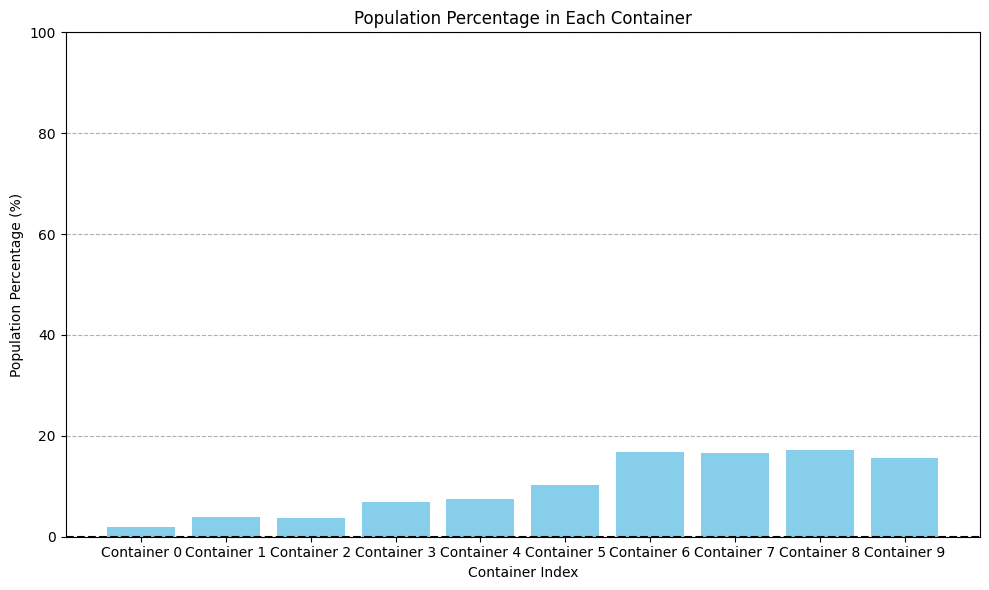

In [42]:
population_percentages = np.array([population_percentage(i) for i in range(len(multipliers))])

# plot the population_percentages
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(range(len(multipliers)), population_percentages * 100, color='skyblue')
plt.xlabel('Container Index')
plt.ylabel('Population Percentage (%)')
plt.title('Population Percentage in Each Container')
plt.xticks(range(len(multipliers)), [f'Container {i}' for i in range(len(multipliers))])
plt.ylim(0, 100)
plt.axhline(y=0, color='k', linestyle='--')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Psychological notes
1. Overselection of High-Multiplier Containers (80x–90x)
Why:

Greed bias: Even rational players are drawn to potential large payoffs.

Cognitive salience: 90x is the max — it feels special.

Risk-seeking under competition: If players think they won't win by playing it safe, they may "swing big."

Effect:
These containers (especially 89x and 90x) may be chosen more frequently than NE predicts, diluting their actual payoff substantially — possibly beyond what players realize.

2. Underselection of Mid-Multiplier, Low-Inhabitant Containers (e.g., 17x–37x)
Why:

Lack of intuitive appeal: They don’t feel like “great deals.”

Too balanced: These are often NE sweet spots, but are ignored in favor of more “obviously good” or “obviously bad” options.

People dislike picking ‘meh’ options even if optimal.

Effect:
These might end up being more profitable than NE predicts, because fewer people select them due to psychological underweighting.

3. Anchoring & Round Number Bias
Why:

Players gravitate toward nice round numbers like 10x, 50x, 90x.

Containers like 31x or 73x might be neglected for being “weird.”

Effect:
Expect an uptick in choices for 10x, 50x, and 90x — even if not justified — and a drop for 31x, 73x.

4. Misunderstanding of the Denominator Effect
Why:

Even smart players may misestimate how percentage usage (10% = 1000 players) dominates the denominator.

They may underestimate how quickly reward gets diluted, especially in high-multiplier crates.

Effect:
Overcrowding of high-multiplier crates, even when mathematically unjustified.

5. Herding Effects
Why:

Even in a simultaneous setting, players will try to second-guess the crowd.

Some players may meta-game and assume “everyone will avoid 90x because it’s too obvious,” so they go for it anyway.

Effect:
Irrational overcrowding on “meta-attractive” crates, particularly 50x, 73x, and 80x.

6. Overselection of First/Last Options
Why:

UI bias / primacy/recency effects — people often choose top-listed or bottom-listed entries, especially under time pressure.

Effect:
Expect 10x and 90x to be overselected.

7. Limited Randomization
Why:

Humans are bad at producing or following truly randomized distributions.

Even when trying to play a mixed strategy, people often favor a few containers “they like” and just rotate.

Effect:
NE mixed strategies will be poorly approximated, favoring predictability over true randomness.

How to Leverage These Deviations
If you're trying to outperform the field, your edge lies in:

Identifying the underpicked NE-optimal containers (e.g., 31x or 37x if they’re underused),

Avoiding high-multiplier traps (like 89x/90x if overused),

Exploiting meta-misperceptions, like the idea that “no one will pick 50x because it’s too obvious.”

# Shorter
How Real Players Deviate from Nash Equilibrium
Overpick high-multiplier crates (80x–90x)
→ Greed, salience, and “go big” mentality lead to overcrowding.

Underpick mid-multiplier crates (17x–37x)
→ They feel “meh” or unexciting, even if optimal.

Bias toward round numbers
→ 10x, 50x, 90x attract attention; 31x, 73x get overlooked.

Poor grasp of denominator mechanics
→ Players underestimate how fast large crates get diluted.

Limited randomness in mixed strategies
→ Players rotate favorites instead of properly randomizing.

# Containers with Psychological Edge vs Nash Prediction:
Underrated (Likely better than NE suggests):
17x, 31x, 37x

Overrated (Worse than NE suggests due to overcrowding):
50x, 80x, 89x, 90x

Wildcard:
10x may be overpicked simply for being first or “safe.”

Want help recalculating expected values assuming biased behavior?